<a href="https://colab.research.google.com/github/roguxivlo/machine-learning-24L/blob/main/hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [36]:
import torch
import torchvision
from matplotlib import pyplot as plt

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

In [37]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [38]:

# First copy the mnist classifier from classes:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [44]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
# For development speed up, only train for 1 epoch:
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)

        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()



Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3054792881011963
epoch: 0 batch: 1 current batch loss: 2.0920190811157227
epoch: 0 batch: 2 current batch loss: 1.6522940397262573
epoch: 0 batch: 3 current batch loss: 1.2257885932922363
epoch: 0 batch: 4 current batch loss: 1.0435422658920288
epoch: 0 batch: 5 current batch loss: 1.1277741193771362
epoch: 0 batch: 6 current batch loss: 0.8910256028175354
epoch: 0 batch: 7 current batch loss: 0.7244992852210999
epoch: 0 batch: 8 current batch loss: 0.8045516014099121
epoch: 0 batch: 9 current batch loss: 0.6225122809410095
epoch: 0 batch: 10 current batch loss: 0.5787414908409119
epoch: 0 batch: 11 current batch loss: 0.5844177007675171
epoch: 0 batch: 12 current batch loss: 0.582314133644104
epoch: 0 batch: 13 current batch loss: 0.5254146456718445
epoch: 0 batch: 14 current batch loss: 0.46754810214042664
epoch: 0 batch: 15 current batch loss: 0.42112526297569275
epoch: 0 batch: 16 current batch loss: 0.4234844148159027
epoch: 

In [40]:
# Now we create another model, whose job will be to
# generate an image that MNIST classifier thinks
# to be a given digit


class Anti_MNIST(torch.nn.Module):
    def __init__ (self, trained_classifier):
        super().__init__()
        self.imgs = torch.nn.Parameter(torch.randn((10, 1, 28, 28)))
        self.classifier = trained_classifier # Ensure this is trained!

    def forward(self, _): # ignore x, we don't care
        output = self.classifier(self.imgs)
        return output




In [41]:
# Let's now train our anti_mnist classifier:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net.eval()
for param in net.parameters():
    param.requires_grad = False


anti_model = Anti_MNIST(net).to(device)
optimizer = torch.optim.Adam(anti_model.parameters(), 0.001)

anti_model.train()

goal_vector = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)

for epoch in range(5):
    optimizer.zero_grad()
    output = anti_model(0) # x doesn't matter

    loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

    loss.backward()       #this computes gradients as we have seen in previous workshops
    optimizer.step()


Working on cuda



Predicted labels for generated images: [3, 2, 2, 5, 2, 2, 1, 7, 7, 3]


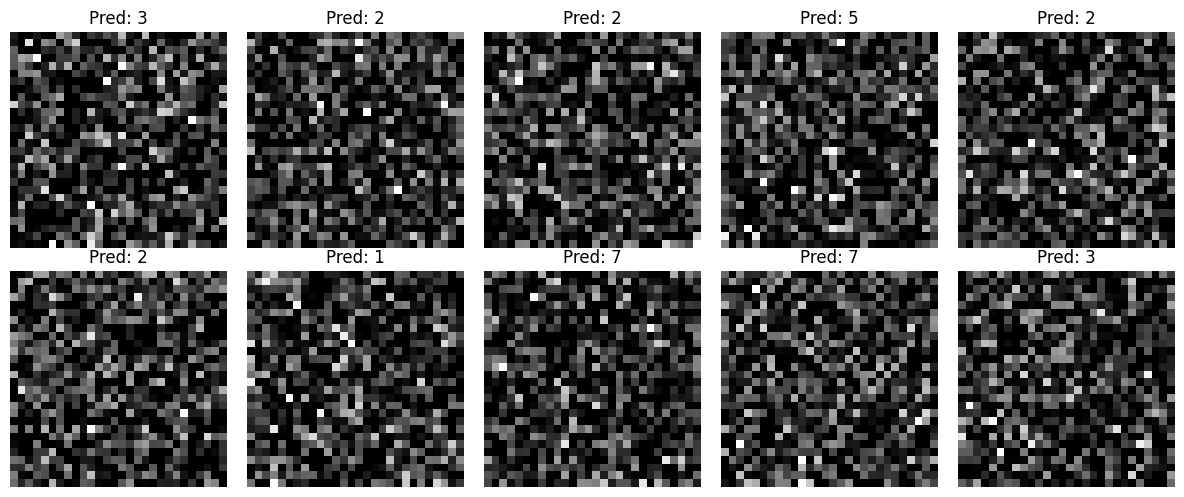

In [42]:
# Get the images from the anti_model:

anti_model.eval()
with torch.no_grad():
    final_output = anti_model(0)
    predicted_labels = torch.argmax(final_output, dim=1)
    print(f"\nPredicted labels for generated images: {predicted_labels.tolist()}")


generated_images = anti_model.imgs.detach().cpu().squeeze(1).numpy()
# Define the mean and standard deviation used for original normalization
mean = 0.1307
std = 0.3081


denormalized_images = generated_images * std + mean
denormalized_images = denormalized_images.clip(0, 1) # Clamp values to be between 0 and 1


# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # 2 rows, 5 columns for 10 images
axes = axes.flatten() # Flatten the 2x5 array of axes for easy iteration

for i in range(10):
    # Display each image
    axes[i].imshow(denormalized_images[i], cmap='gray')
    # Set title with the predicted label
    axes[i].set_title(f"Pred: {predicted_labels[i].item()}")
    axes[i].axis('off') # Hide axes ticks

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot